# Supervised Learning for Drug Design
The drug development process by which new medications are discovered, developed, and tested before being brought to market is notoriously long and expensive, often taking years or even decades and costing billions to come up with a single new drug. If a new drug development company's first drug doesn't make it through pre-clinical and clinical trials (which is often the case) they are unlikely to receive further funding and are liable to go bankrupt.

Whilst the restrictions and regulations that exist are practically unavoidable (and there for good reason), using machine learning techniques to select drug-like molecules that are more likely to have desirable qualities is bound to result in more a efficient drug development process, saving company and investor money, and ultimately yielding higher quality medications in higher quantities for the public.

Machine learning techniques are already widely used in drug design and development. Many of these make use of deep learning and neural networks, but some simpler (and more interpretable) models also find their use. Since this course dealt with supervised learning methods (not including deep learning methods) I will be making use of various ensemble models (namely random forests and boosting).

# Problem Description: Prediction of Failure in Clinical Trials and FDA Approval
The primary end goal of the drug development process is to have a prospective drug approved by the FDA at which point it is essentially greenlit for use by and sale to the public. If in clinical trials a drug is found to be significantly harmful when consumed it will be denied by the FDA, and so weeding these out before time and money is spent on clinical trials is paramount. In this project I intend to make use of random forests, gradient boosting, and AdaBoost to train a classifier to do just that (and figure out which of the three methods is most suited to doing so in the process).


In [1]:
import pandas as pd
import numpy as np

!pip install --pre deepchem
import deepchem as dc

import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The Data: Tox21 Dataset
The dataset I will be using for this project is the Tox21 dataset from MoleculeNet. 

The Tox21 dataset includes “Qualitative toxicity measurements on 12 biological targets, including nuclear receptors and stress response pathways.” (Wu et al., 2017). Ideally we would have our drug candidate molecule not be toxic at all.

The Tox21 dataset and others from the MoleculeNet paper can be found at the following URL: https://moleculenet.org/datasets-1

The Tox21 dataset includes 7831 entries, each referring to a single compound, and 13 columns:

*   **smiles**, a SMILES format string. This encodes the molecule's atomic structure and will be where we extract all our features from.
*   The other twelve columns represent categorical toxicity measurements (1 means toxicity was found, 0 means that is was not) corresponding to different biological targets. Unfortunately, not every row has a value for each target, so it will be important to figure out what to do with these.


It's worth noting that toxicity and and FDA approval are not necessarily mutually exclusive, though they are significantly inversely correlated. A drug might not be toxic but be denied for other reasons, and some toxic drugs might be approved by the FDA, for example those intended for terminally ill patients where the benefits of the drug outweigh any damage done by toxicity.




In [2]:
tox21 = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz")

In [3]:
tox21.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


# Feature Extraction
Our 'smiles' column is just a string. In order to get useful information from these strings for our models we will have to perform some feature extraction. The [DeepChem](https://deepchem.io/) library provides a number of useful molecular featurizers, my favorite of which is graph convolutions. Molecules happen to be very well suited to representation as a graph of the atoms that they're made of, and the graph convolution featurizer performs convolutions over this graph to capture information about the relationships between atoms and atomic groups within a molecule, not entirely dissimilarly to how convolutions are used in computer vision and image processing to capture relationships between pixels (although unlike image data, molecules in graph representation generally don't fall on a perfectly rectangular coordinate plane). Graph convolutions of molecules tend to be very useful for molecular machine learning, but unfortunately they aren't entirely deterministic and so results may vary. 

For the purposes of this assignment I will use the Extended-Connectivity Fingerprints featurizer to produce some deterministic features from the smiles data. The fingerprint featurizer will create a bunch of new features representing whether or not the molecule in question contains that specific substructure.

Hopefully this will allow me to find which substructures contribute significantly to a molecule's toxicity, as this would be a valuable insight to have not only for weeding out bad molecules ahead of time, but also for the purposes of designing a new candidate molecule and understanding the underlying chemistry.

In [4]:
featurizer = dc.feat.CircularFingerprint(sparse=False, smiles=True, size=1024, radius=2)

In [5]:
features = featurizer.featurize(tox21['smiles'])

In [6]:
f = pd.DataFrame(features.tolist())

In [7]:
# Combine the tox21 dataset with the newly created features
df = tox21.join(f)

In [8]:
df.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Data Cleaning and Exploratory Data Analysis

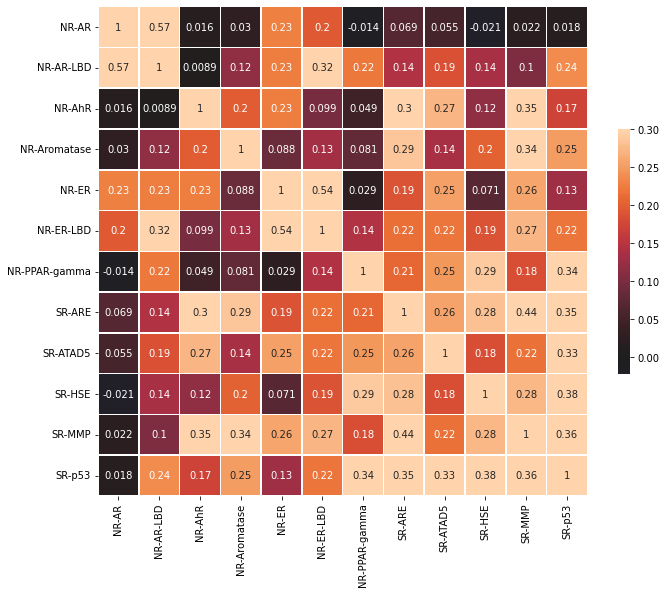

In [36]:
#Correlation matrix of different toxicities
corr = tox21.corr()

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It looks like toxicity is weakly correlated across most target areas, which isn't entirely surprising. For the purposes of this project it won't make sense to use toxicity measurements to predict each other as the end goal is to predict toxicity in molecules that are yet to be studied.

In [37]:
#Making sure none of the columns only contain one unique value:
print("Proportion of rows missing values in columns: ")
for col in tox21.columns:
  print(col + ": " + str(tox21[col].isna().sum()/len(tox21)))

Proportion of rows missing values in columns: 
NR-AR: 0.0722768484229345
NR-AR-LBD: 0.13701953773464437
NR-AhR: 0.16370833865406717
NR-Aromatase: 0.2566722002298557
NR-ER: 0.2091686885455242
NR-ER-LBD: 0.1118631081598774
NR-PPAR-gamma: 0.17635040224747797
SR-ARE: 0.2552675264972545
SR-ATAD5: 0.09692248754948282
SR-HSE: 0.17417954284254886
SR-MMP: 0.2580768739624569
SR-p53: 0.1349763759417699
mol_id: 0.0
smiles: 0.0


It looks as though we are missing a lot of values. For the purposes of this assignment and for the sake of simplicity I will look at only the NR-AR target as it has the most data available.

In [9]:
# Dropping the columns corresponding to targets I won't analyze in this assignment, as well as "mol_id" as it doesn't correspond to any meaningful information
df = df.drop(columns = ["NR-AR-LBD", "NR-AhR", "NR-Aromatase", "NR-ER", "NR-ER-LBD", "NR-PPAR-gamma", "SR-ARE", "SR-ATAD5", "SR-HSE", "SR-MMP", "SR-p53", "mol_id"])

Instead of imputing the missing values, I'm going to elect to drop them under the assumption that the data is missing for a reason (for example, that the molecule in question doesn't ever come into contact with that receptor in practice, and so even if it were theoretically toxic it wouldn't ever be a problem).

In [10]:
# Dropping rows where NR-AR toxicity hasn't been measured
df = df.dropna(subset=['NR-AR'])

In [11]:
df.head()

,NR-AR,smiles,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Checking for columns corresponding to substructures not found in any of our smiles molecules

cols_to_drop = []

for col in df.iloc[:,2:]:
  if df[col].sum() == 0:
    cols_to_drop.append(col)

print(len(cols_to_drop))

0


In [42]:
df = df.drop(columns = cols_to_drop)

In [15]:
print(featurizer)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
df.head()

,NR-AR,smiles,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Getting the names of the substructures

colnames = ["NR-AR", "smiles"]

for col in df.iloc[:,2:]:
  colnames.append(df[col][df[col].first_valid_index()]['smiles'])

In [45]:
df.columns = colnames

In [46]:
count = 0
for col in colnames:
  if col == '':
    count = count + 1

print(count)

# A lot of empty smiles entries

157


In [47]:
df = df.drop(columns = '')

In [59]:

df = df.fillna(0)

In [60]:
df.head()

,NR-AR,smiles,cc(O)cc(c)s,cc(c)OCC,cc(c)nc(s)S,ccc(cc)OC,ccc,ccc,cnc,ccc(sc)c(c)n,...,CC(O)CC(N)=O,CCN(CC)C(C)=O,CC(O)CN(C)C,c[nH]c(c([nH])=O)c(n)n,cn(c)CCC,cc(n)n(CC)c([nH])=O,cnc(c(c)[nH])n(c)C,cc(C)c(OC)c(c)O,cCN(CC)C(c)C,cc(c)CN(C)C
0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,"{'smiles': 'cc(O)cc(c)s', 'count': 1}","{'smiles': 'cc(c)OCC', 'count': 1}","{'smiles': 'cc(c)nc(s)S', 'count': 1}","{'smiles': 'ccc(cc)OC', 'count': 1}","{'smiles': 'ccc', 'count': 2}","{'smiles': 'ccc', 'count': 1}","{'smiles': 'cnc', 'count': 1}","{'smiles': 'ccc(sc)c(c)n', 'count': 1}",...,0,0,0,0,0,0,0,0,0,0
1,0.0,CCN1C(=O)NC(c2ccccc2)C1=O,0,0,0,0,"{'smiles': 'ccc', 'count': 2}",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0,0,0,0,"{'smiles': 'ccc', 'count': 2}",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Getting substructure occurences from the dictionaries they're in
#cols = df.iloc[:,2:].columns
#df[cols] = df[cols].applymap(lambda x: x['count'])

TypeError: ignored

#Modeling

As I stated in the introduction, I'm interested in trying out boosting methods and random forests as models for this data. I think that these will work well as the bag-of-words style fingerprint featurization has created relatively high dimension data, and so models that suffer from the curse of dimensionality are unlikely to perform very well.

In [42]:
# Re-importing the data to conserve RAM
n_features = 1024
tasks, datasets, transformers = dc.molnet.load_tox21(featurization='ecfp')
tasks = [tasks[0]]

# dropping unecessary tasks again
to_drop = ["w" + str(i) for i in range(1,13)] +  ["y" + str(i) for i in range(2,13)]

# combining datasets as they were pre-split and I'd like to do cross-validation later
train_dataset, valid_dataset, test_dataset = datasets
df = pd.concat([train_dataset.to_dataframe(), valid_dataset.to_dataframe(), test_dataset.to_dataframe()]).drop(columns = to_drop)


Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10',
       ...
       'X1017', 'X1018', 'X1019', 'X1020', 'X1021', 'X1022', 'X1023', 'X1024',
       'y1', 'ids'],
      dtype='object', length=1026)


In [132]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import RocCurveDisplay

First, the random forest classifier.

In [69]:
rfc = RandomForestClassifier()

n_est_vals = [pow(2, i) for i in range(6, 11)]
min_samples_vals = [i for i in range(2, 5)]

parameters = {'n_estimators':n_est_vals, 'min_samples_split':min_samples_vals}

rfc_grid = GridSearchCV(rfc, parameters, scoring='roc_auc', verbose=10, cv = 3)

rfc_grid.fit(df.iloc[:,0:1023], df['y1'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 1/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.812 total time=   1.2s
[CV 2/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 2/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.754 total time=   1.2s
[CV 3/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 3/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.742 total time=   1.3s
[CV 1/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 1/3; 2/15] END min_samples_split=2, n_estimators=128;, score=0.802 total time=   2.3s
[CV 2/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 2/3; 2/15] END min_samples_split=2, n_estimators=128;, score=0.763 total time=   2.4s
[CV 3/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 3/

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': [2, 3, 4],
                         'n_estimators': [64, 128, 256, 512, 1024]},
             scoring='roc_auc', verbose=10)

In [122]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

def plotSearchGrid(grid,vmin=0.7, vmax = 1, midpoint=0.9, y = "n_estimators", x = "min_samples_split"):
    """
    parameters:
      GridSearchCV object

    returns:
      plot of search
    """
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid[x]), len(grid.param_grid[y]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=vmin, vmax = vmax, midpoint=midpoint))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid[x])), grid.param_grid[x], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid[y])), grid.param_grid[y])
    plt.title('ROC AUC')
    plt.show()

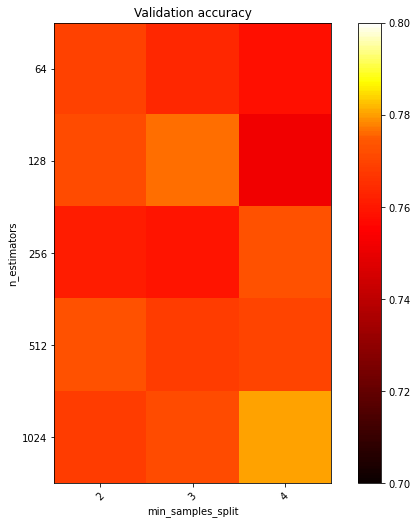

In [120]:
plotSearchGrid(rfc_grid, vmin=0.7, vmax = .8, midpoint=0.775)

In [117]:
print(rfc_grid.best_params_)

print(rfc_grid.best_score_)


{'min_samples_split': 4, 'n_estimators': 1024}
0.7803499939257427


Reminder that the scoring method is the area under the ROC curve. 78% is not bad! I believe that even better scores could be obtained by further exploring parameter combinations as the best parameters were also the highest that the search tested.

Gradient boosting:

In [106]:
gbc = GradientBoostingClassifier()

n_est_vals = [pow(2, i) for i in range(6, 11)]
min_samples_vals = [i for i in range(2, 5)]

parameters = {'n_estimators':n_est_vals, 'min_samples_split':min_samples_vals}

gbc_grid = GridSearchCV(gbc, parameters, scoring='roc_auc', verbose=10, cv = 3)

gbc_grid.fit(df.iloc[:,0:1023], df['y1'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 1/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.789 total time=   4.3s
[CV 2/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 2/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.737 total time=   4.1s
[CV 3/3; 1/15] START min_samples_split=2, n_estimators=64.......................
[CV 3/3; 1/15] END min_samples_split=2, n_estimators=64;, score=0.720 total time=   4.0s
[CV 1/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 1/3; 2/15] END min_samples_split=2, n_estimators=128;, score=0.786 total time=   8.4s
[CV 2/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 2/3; 2/15] END min_samples_split=2, n_estimators=128;, score=0.713 total time=   8.2s
[CV 3/3; 2/15] START min_samples_split=2, n_estimators=128......................
[CV 3/

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'min_samples_split': [2, 3, 4],
                         'n_estimators': [64, 128, 256, 512, 1024]},
             scoring='roc_auc', verbose=10)

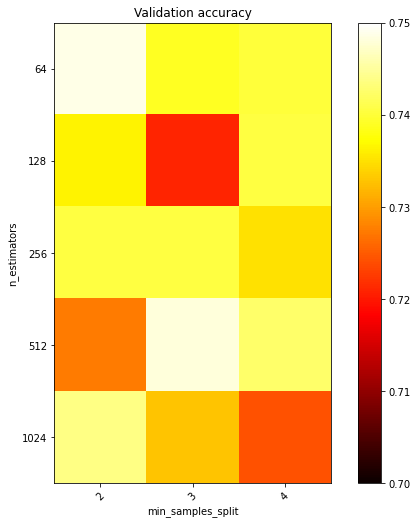

In [111]:
plotSearchGrid(gbc_grid,vmin=0.7, vmax = .75, midpoint=0.725)

In [112]:
print(gbc_grid.best_params_)

print(gbc_grid.best_score_)


{'min_samples_split': 2, 'n_estimators': 64}
0.7488098397804924


AdaBoost:

In [107]:
abc = AdaBoostClassifier()

n_est_vals = [pow(2, i) for i in range(6, 11)]
learning_rate_vals = [pow(2, i) for i in range(-3, 3)]

parameters = {'n_estimators':n_est_vals, 'learning_rate':learning_rate_vals}

abc_grid = GridSearchCV(abc, parameters, scoring='roc_auc', verbose=10, cv = 3)

abc_grid.fit(df.iloc[:,0:1023], df['y1'])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START learning_rate=0.125, n_estimators=64.......................
[CV 1/3; 1/30] END learning_rate=0.125, n_estimators=64;, score=0.768 total time=   3.2s
[CV 2/3; 1/30] START learning_rate=0.125, n_estimators=64.......................
[CV 2/3; 1/30] END learning_rate=0.125, n_estimators=64;, score=0.691 total time=   3.1s
[CV 3/3; 1/30] START learning_rate=0.125, n_estimators=64.......................
[CV 3/3; 1/30] END learning_rate=0.125, n_estimators=64;, score=0.650 total time=   3.1s
[CV 1/3; 2/30] START learning_rate=0.125, n_estimators=128......................
[CV 1/3; 2/30] END learning_rate=0.125, n_estimators=128;, score=0.772 total time=   6.2s
[CV 2/3; 2/30] START learning_rate=0.125, n_estimators=128......................
[CV 2/3; 2/30] END learning_rate=0.125, n_estimators=128;, score=0.650 total time=   6.2s
[CV 3/3; 2/30] START learning_rate=0.125, n_estimators=128......................
[CV 3/

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.125, 0.25, 0.5, 1, 2, 4],
                         'n_estimators': [64, 128, 256, 512, 1024]},
             scoring='roc_auc', verbose=10)

In [108]:
print(abc_grid.best_params_)

print(abc_grid.best_score_)


{'learning_rate': 4, 'n_estimators': 64}
0.7080983371313218


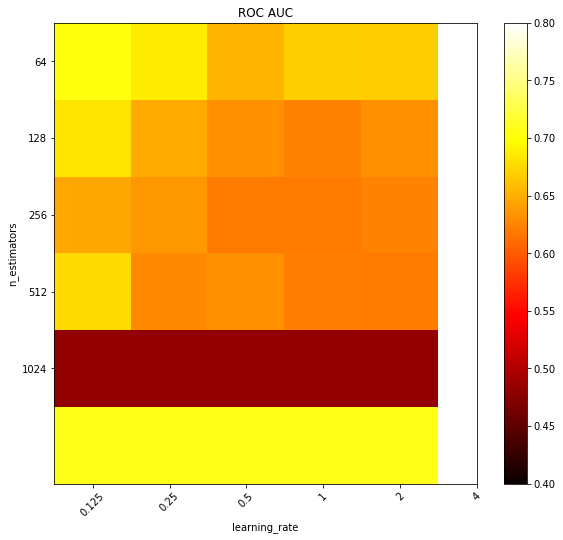

In [127]:
plotSearchGrid(abc_grid,vmin=0.4, vmax = .8, midpoint=0.6, x = 'learning_rate')

#Results and Analysis
Now that we have our optimized hyperparameters we can compare the models.

In [133]:

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:1023], df['y1'], test_size=0.2)

rfc = RandomForestClassifier(min_samples_split = 4, n_estimators= 1024)
gbc = GradientBoostingClassifier(min_samples_split = 2, n_estimators= 64)
abc = AdaBoostClassifier(learning_rate = 4, n_estimators = 64)

models = [rfc, gbc, abc]

for model in models:
  model.fit(X_train, y_train)


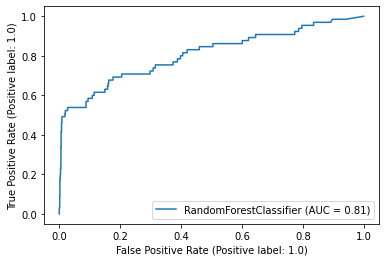

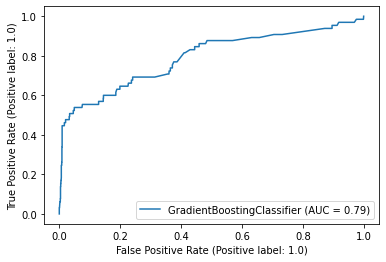

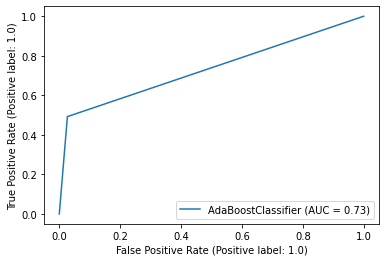

In [138]:
for m in models:
  RocCurveDisplay.from_estimator(m, X_test, y_test)

All three models ended up performing quite decently, but the random forest classifier did the best with an ROC AUC of .81, which is impressively on par with the models trained for the MoleculeNet paper.

#Discussion and Conclusion
It appears that my assumption that ensemble methods would perform decently at classifying toxic molecules turned out to be correct, which, again, I presume is because of the high dimension nature of the molecular fingerprint featurization (which ensemble methods are suited to due to their resistance to the curse of dimensionality). 

Many of the top performing models on this same dataset from the MoleculeNet benchmark involve more complexity (the best being a convolutional neural network, achieving an ROC AUC of nearly 100%), so I am proud that my relatively simple models were able to achieve scores anywhere near that.
If I were to repeat this project, I would want to expand the GridSearchCV to include larger parameters as it seemed that my search wasn't exhaustive enough (but computational limitations made it difficult to expand the search). I would also go back and create models for toxicity on all 12 of the biological targets so as to get a more universal sense of the molecules' levels of toxicity.

#Bibliography

Zhenqin Wu, Bharath Ramsundar, Evan N. Feinberg,  Joseph Gomes, Caleb Geniesse, Aneesh S. Pappu, Karl Leswingd and Vijay Pande. (2017). *MoleculeNet: A Benchmark for Molecular Machine Learning*. Chemical Science. https://doi.org/10.1039/C7SC02664A